# Pneumonia X-Ray Image Classification: Modeling

Authors:
- Arthur Kim
    - Github: arthurk2323
- Mia Fryer
    - Github: miazfryer
- Ian Sharff
    - Github: iansharff
___

## Data Preparation and Loading

In [1]:
import os
import sys
import pickle
import PIL
from PIL import Image
import io
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator,\
array_to_img,\
img_to_array,\
load_img

from tensorflow.keras.models import load_model

import tools.visualizations as vis
import tools.misc as misc

In [2]:
# Path Constants
TRAIN_PATH = 'data/split/train'
VAL_PATH = 'data/split/val'
TEST_PATH = 'data/split/test'

# Image Processing Constants
BATCH_SIZE = 32
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Change for test runs
EPOCHS = 30

In [3]:
# Call function to display counts and return dict of subtotals
counts = misc.count_files([TRAIN_PATH, VAL_PATH, TEST_PATH])


TRAIN
-------------------------
	PNEUMONIA: 2564
	NORMAL: 950

	SUBTOTAL: 3514
VAL
-------------------------
	PNEUMONIA: 855
	NORMAL: 317

	SUBTOTAL: 1172
TEST
-------------------------
	PNEUMONIA: 854
	NORMAL: 316

	SUBTOTAL: 1170
-------------------------
TOTAL: 5856 files


In [4]:
counts

{'train': 3514, 'val': 1172, 'test': 1170}

In [5]:
# DirectoryIterator parameters for flow_from_directory
gen_params = {
    'target_size': (64, 64),
    'color_mode': 'grayscale',
    'class_mode': 'binary',
}

In [6]:
## CALLBACKS

Here, the images are accessed through `ImageDataGenerator`s and rescaled. The batch sizees are set to the file count for a given subset (training, validation, and testing) within the `flow_from_directory` method call, so all images are saved to memory as 64x64 grayscale images (shape = (n_images, 64, 64, 1)) upon calling `next` on the `DirectoryIterators` produced. 

In [7]:
# Load 
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TRAIN_PATH, 
    batch_size=counts['train'],
    **gen_params
)

# Get all the data in the directory data/val (855+317 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VAL_PATH, 
    batch_size=counts['val'],
    **gen_params
)

# Get all the data in the directory data/test (854+316 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_PATH,
    batch_size=counts['test'],
    **gen_params
)

Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [8]:
# Create the datasets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [9]:
# Display the shape of the image and label arrays (this cell may take a while to load)
print('TRAIN\n' + '-'*50)
print(f'\ttrain_images shape: {train_images.shape}')
print(f'\ttrain_labels shape: {train_labels.shape}')
print('\nVALIDATION\n' + '-'*50)
print(f'\tval_images shape: {val_images.shape}')
print(f'\tval_labels shape: {val_labels.shape}')
print('\nTEST\n' + '-'*50)
print(f'\ttest_images shape: {test_images.shape}')
print(f'\ttest_labels shape: {test_labels.shape}')
    

TRAIN
--------------------------------------------------
	train_images shape: (3514, 64, 64, 1)
	train_labels shape: (3514,)

VALIDATION
--------------------------------------------------
	val_images shape: (1172, 64, 64, 1)
	val_labels shape: (1172,)

TEST
--------------------------------------------------
	test_images shape: (1170, 64, 64, 1)
	test_labels shape: (1170,)


In [10]:
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     TRAIN_PATH,
#     seed=123,
#     color_mode='grayscale',
#     label_mode='binary',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE
# )

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     VAL_PATH,
#     seed=123,
#     color_mode='grayscale',
#     label_mode='binary',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE
# )

# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     TEST_PATH,
#     seed=123,
#     color_mode='grayscale',
#     label_mode='binary',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE
# )

In [11]:
class_weight = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels,
)

In [12]:
class_names = {v: k for k, v in train_generator.class_indices.items()}
print(class_names)

{0: 'NORMAL', 1: 'PNEUMONIA'}


In [13]:
# ## GET SAMPLE IMAGES
# for dirpath, dirnames, filenames in os.walk():
#     for dirname in dirnames:
#         if dirname == 'BACTERIA':
#             bacteria = load_img(os.path.join(dirname))
# vir_samples = [
#     'data/VIRUS/person1_virus_11.jpeg',
#     'data/VIRUS/person1_virus_12.jpeg',
#     'data/VIRUS/person1_virus_13.jpeg',
# ]

# bac_samples = [
#     'data/BACTERIA/person1_bacteria_1.jpeg',
#     'data/BACTERIA/person1_bacteria_2.jpeg',
#     'data/BACTERIA/person10_bacteria_43.jpeg'
# ]

# norm_samples = [
#     'data/NORMAL/IM-0001-0001.jpeg',
#     'data/NORMAL/IM-0001-0001.jpeg',
#     'data/NORMAL/IM-0001-0001.jpeg'
# ]

# fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# for 
        

# ## PLOT SAMPLE IMAGES
# with plt.style.context('images/presentation.mplstyle'):
#     fig, axes = plt.subplots(2, 3, figsize=(10, 8))
#     for i, ax in enumerate(axes.flatten()):
#         if i < 3:
#             ax.imshow(norm_samples[i], cmap=plt.cm.binary)
#             ax.set_xticks([])
#             ax.set_yticks([])
#             ax.set_title('NORMAL')
#         else:
#             ax.imshow(pneu_samples[i-4], cmap=plt.cm.binary)
#             ax.set_xticks([])
#             ax.set_yticks([])
#             ax.set_title('PNEUMONIA', color='darkred')
#     fig.tight_layout()
#     plt.axis('off')
#     plt.show()

#### Sample Images

In [14]:
vir_samples = [
    'data/VIRUS/person1_virus_11.jpeg',
    'data/VIRUS/person1_virus_12.jpeg',
    'data/VIRUS/person1_virus_13.jpeg',
]

bac_samples = [
    'data/BACTERIA/person1_bacteria_1.jpeg',
    'data/BACTERIA/person1_bacteria_2.jpeg',
    'data/BACTERIA/person10_bacteria_43.jpeg'
]

norm_samples = [
    'data/NORMAL/IM-0001-0001.jpeg',
    'data/NORMAL/IM-0001-0001.jpeg',
    'data/NORMAL/IM-0001-0001.jpeg'
]

In [15]:
plt.style.use('images/presentation.mplstyle')

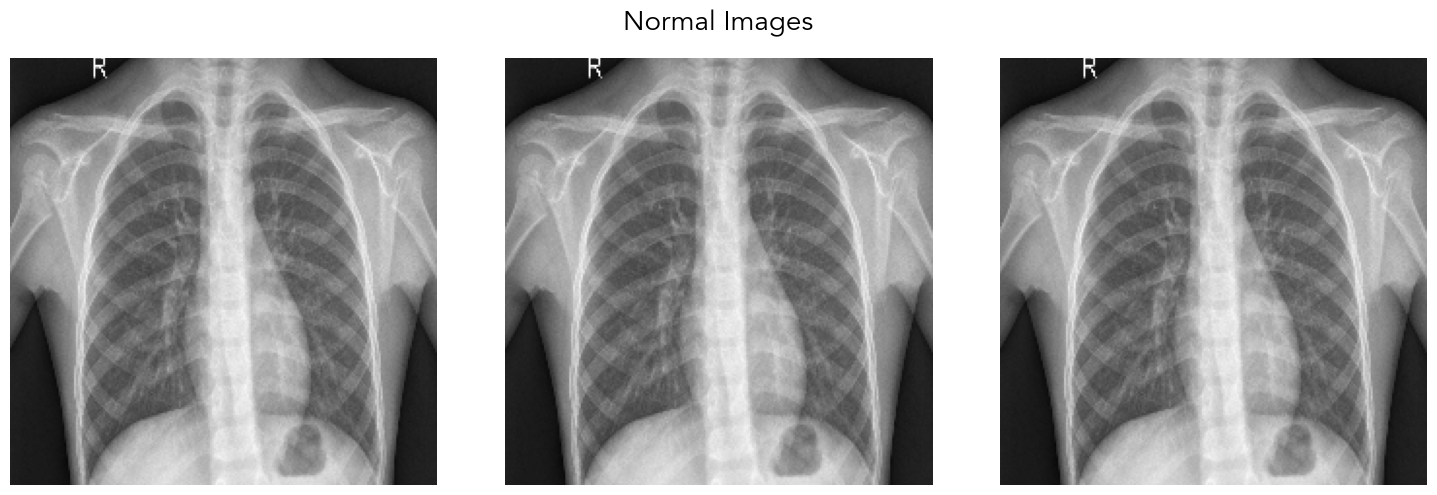

In [16]:
### MAKE FUNCTION
import glob
import cv2
normal = glob.glob(TRAIN_PATH+"NORMAL/*.jpeg")
pneumonia = glob.glob(TRAIN_PATH+"PNEUMONIA/*.jpeg")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(norm_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Normal Images")
fig.tight_layout()       
plt.show()
plt.savefig('images/norm_samples.png')

<Figure size 1000x700 with 0 Axes>

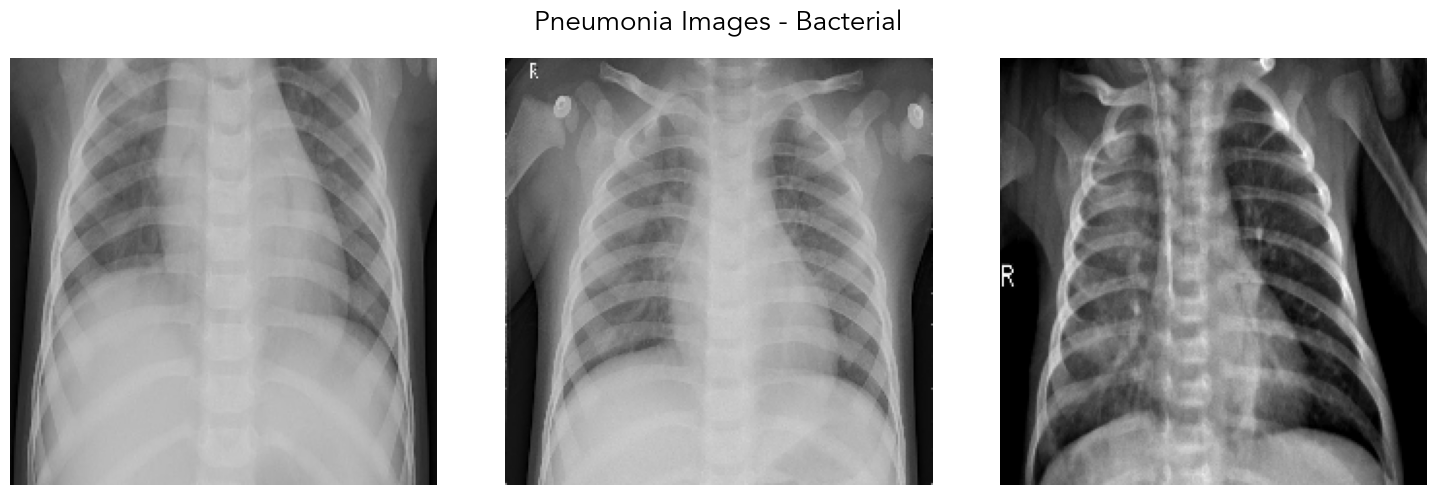

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(bac_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Pneumonia Images - Bacterial")
fig.tight_layout()
plt.show()
plt.savefig('images/bac_samples.png')

<Figure size 1000x700 with 0 Axes>

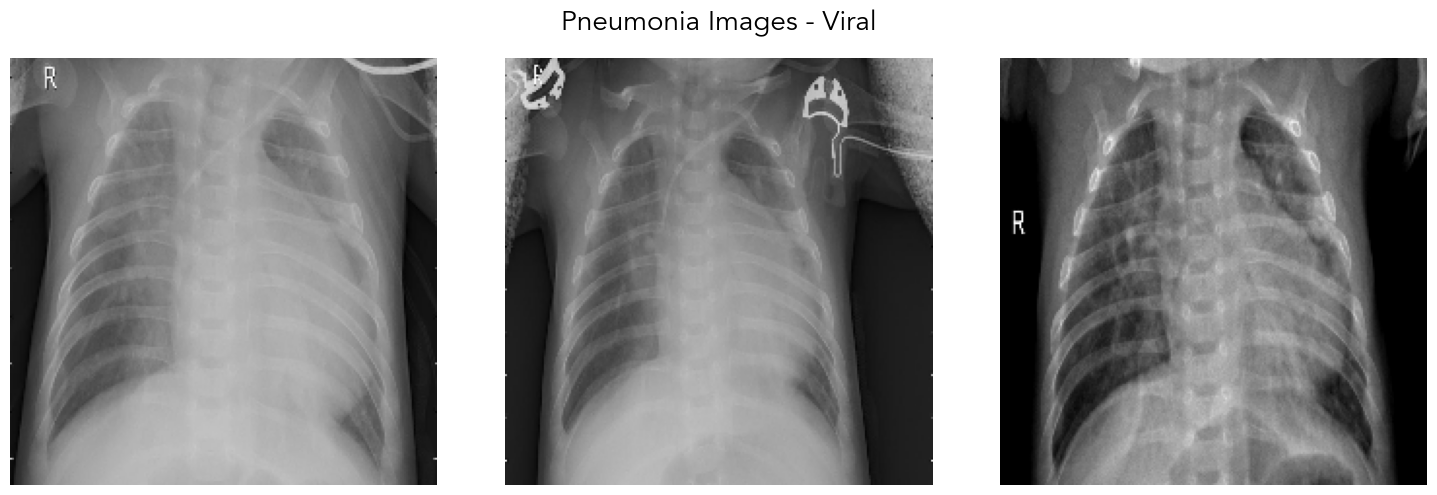

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(vir_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Pneumonia Images - Viral")
fig.tight_layout()   
plt.show()
plt.savefig('images/vir_samples.png')

## Model Building and Evaluation

### Dummy Model

In [19]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(train_images, train_labels)

DummyClassifier(strategy='most_frequent')

In [20]:
dummy_clf.score(train_images, train_labels)

0.7296528173022196

In [21]:
dummy_clf.score(val_images,val_labels)

0.7295221843003413

In [22]:
dummy_clf.score(test_images,test_labels)

0.7299145299145299

### Model 1: Baseline Neural Network

In [23]:
# np.random.seed(123)
# model1 = models.Sequential()
# model1.add(layers.Flatten(input_shape=(64, 64, 1)))
# model1.add(layers.Dense(2, activation='relu'))

In [24]:
# model1.compile(optimizer='sgd',
#               loss='binary_crossentropy',
#               metrics=['acc'])

# history1 = model1.fit(train_images,
#                      train_labels,
#                      epochs=EPOCHS,
#                      batch_size=BATCH_SIZE,
#                      validation_data=(val_images, val_labels))

Epoch 1/30
110/110 [==============================] - 1s 5ms/step - loss: 4.7640 - acc: 0.7113 - val_loss: 4.1246 - val_acc: 0.7295
Epoch 2/30
110/110 [==============================] - 0s 1ms/step - loss: 4.0200 - acc: 0.7364 - val_loss: 4.1246 - val_acc: 0.7295
Epoch 3/30
110/110 [==============================] - 0s 1ms/step - loss: 4.2090 - acc: 0.7240 - val_loss: 4.1246 - val_acc: 0.7295
Epoch 4/30
110/110 [==============================] - 0s 1ms/step - loss: 3.9961 - acc: 0.7380 - val_loss: 4.1246 - val_acc: 0.7295
Epoch 5/30
110/110 [==============================] - 0s 1ms/step - loss: 4.0396 - acc: 0.7351 - val_loss: 4.1246 - val_acc: 0.7295
Epoch 6/30
110/110 [==============================] - 0s 1ms/step - loss: 3.9925 - acc: 0.7382 - val_loss: 4.1246 - val_acc: 0.7295
Epoch 7/30
110/110 [==============================] - 0s 1ms/step - loss: 4.1316 - acc: 0.7291 - val_loss: 4.1246 - val_acc: 0.7295
Epoch 8/30
110/110 [==============================] - 0s 1ms/step - loss: 4.

<Figure size 1000x700 with 0 Axes>

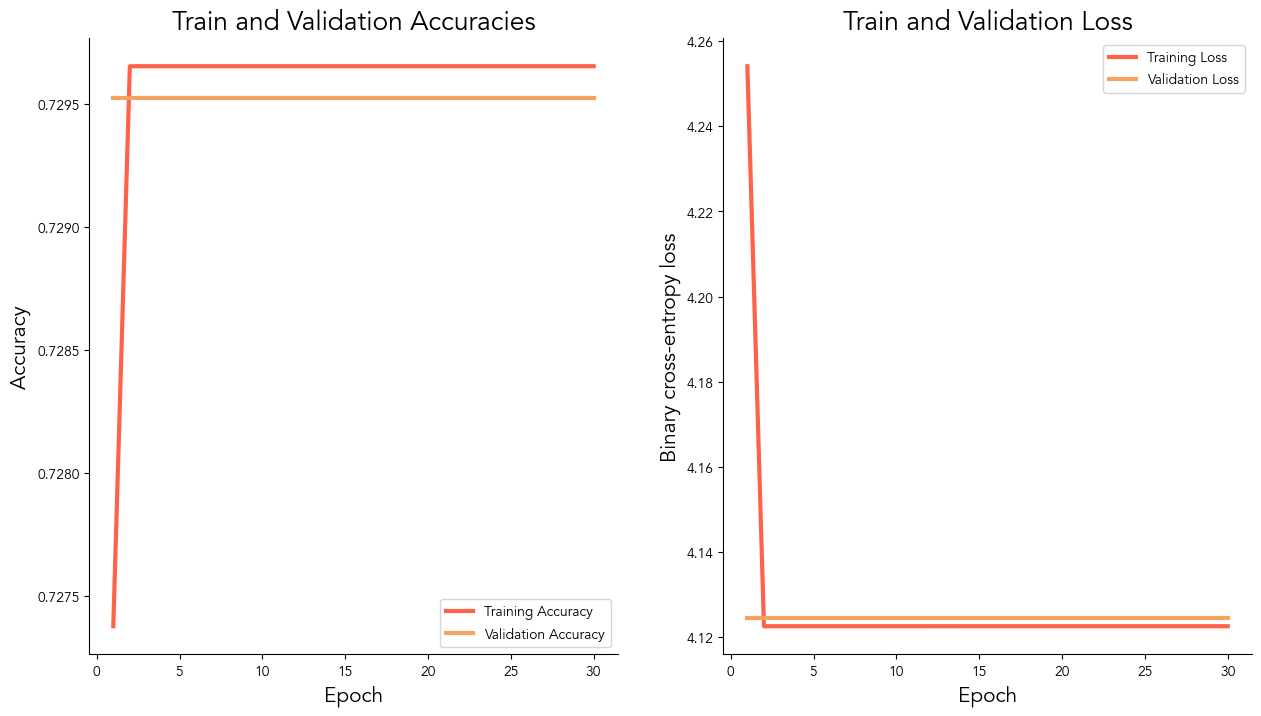

In [25]:
# vis.plot_loss_accuracy(history1)
# plt.show()
# plt.savefig('images/acc_loss_nn_shallow.png')

In [26]:
# vis.plot_confusion_matrices(model1, train_images, test_images, train_labels, test_labels)

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [29]:
results_train = model1.evaluate(train_images, train_labels)

110/110 [==============================] - 0s 1ms/step - loss: 4.1226 - acc: 0.7297


In [30]:
results_test = model1.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 879us/step - loss: 4.1186 - acc: 0.7299


In [31]:
results_train

[4.122590065002441, 0.7296528220176697]

In [32]:
results_test

[4.118597507476807, 0.7299145460128784]

### Model 2: Neural Network with Dense Layers

In [33]:
np.random.seed(123)
model2 = models.Sequential()
model2.add(layers.Flatten(input_shape=(64, 64, 1)))
model2.add(layers.Dense(200, activation='relu'))
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(50, activation='relu'))
model2.add(layers.Dense(25, activation='relu'))
model2.add(layers.Dense(7, activation='relu'))
model2.add(layers.Dense(5, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [34]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

history2 = model2.fit(train_images,
                     train_labels,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=(val_images, val_labels))

Epoch 1/30
110/110 [==============================] - 1s 6ms/step - loss: 0.5642 - acc: 0.7206 - val_loss: 0.4356 - val_acc: 0.7295
Epoch 2/30
110/110 [==============================] - 1s 5ms/step - loss: 0.4450 - acc: 0.7269 - val_loss: 0.4004 - val_acc: 0.8865
Epoch 3/30
110/110 [==============================] - 1s 5ms/step - loss: 0.3895 - acc: 0.8396 - val_loss: 0.3134 - val_acc: 0.9036
Epoch 4/30
110/110 [==============================] - 1s 6ms/step - loss: 0.3248 - acc: 0.8843 - val_loss: 0.2965 - val_acc: 0.9138
Epoch 5/30
110/110 [==============================] - 1s 5ms/step - loss: 0.3231 - acc: 0.8898 - val_loss: 0.3320 - val_acc: 0.8729
Epoch 6/30
110/110 [==============================] - 0s 4ms/step - loss: 0.2987 - acc: 0.8927 - val_loss: 0.2696 - val_acc: 0.9087
Epoch 7/30
110/110 [==============================] - 1s 5ms/step - loss: 0.2865 - acc: 0.9019 - val_loss: 0.2666 - val_acc: 0.9113
Epoch 8/30
110/110 [==============================] - 1s 5ms/step - loss: 0.

In [96]:
# Save model
model2.save('models/model2.h5')

<Figure size 1000x700 with 0 Axes>

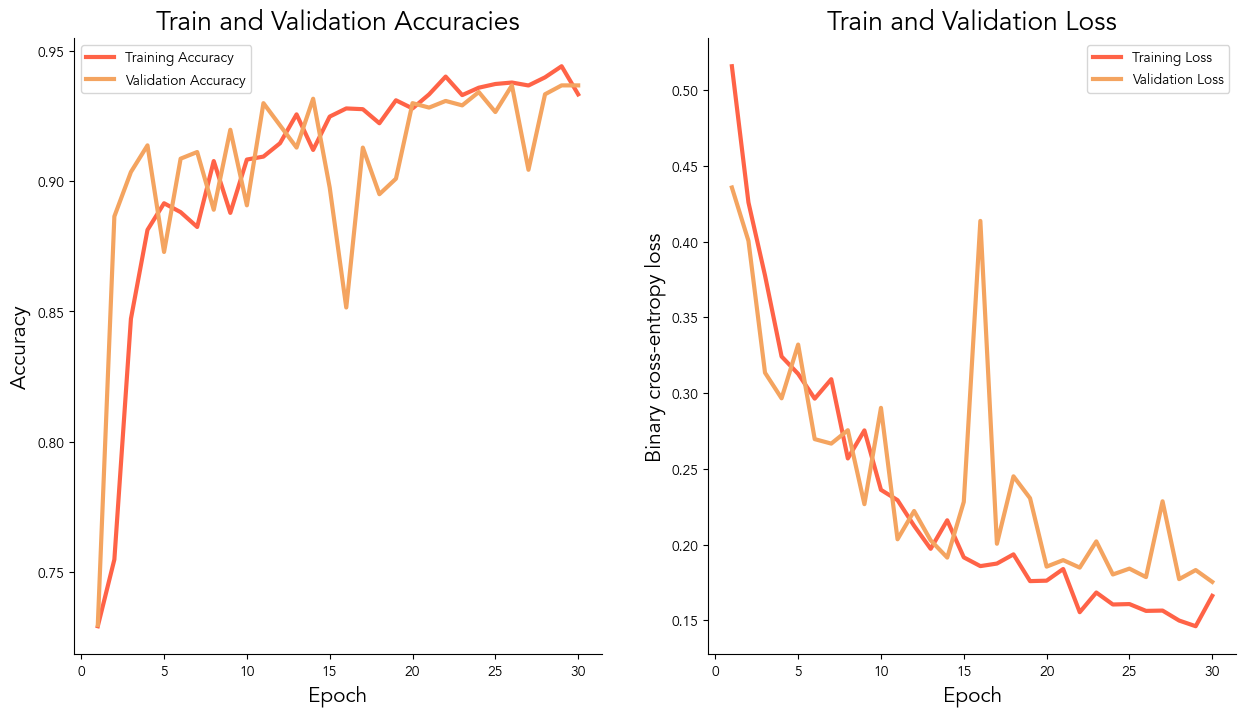

In [97]:
vis.plot_loss_accuracy(history2)
plt.show()
plt.savefig('images/acc_loss/al_model2.png')

<Figure size 1000x700 with 0 Axes>

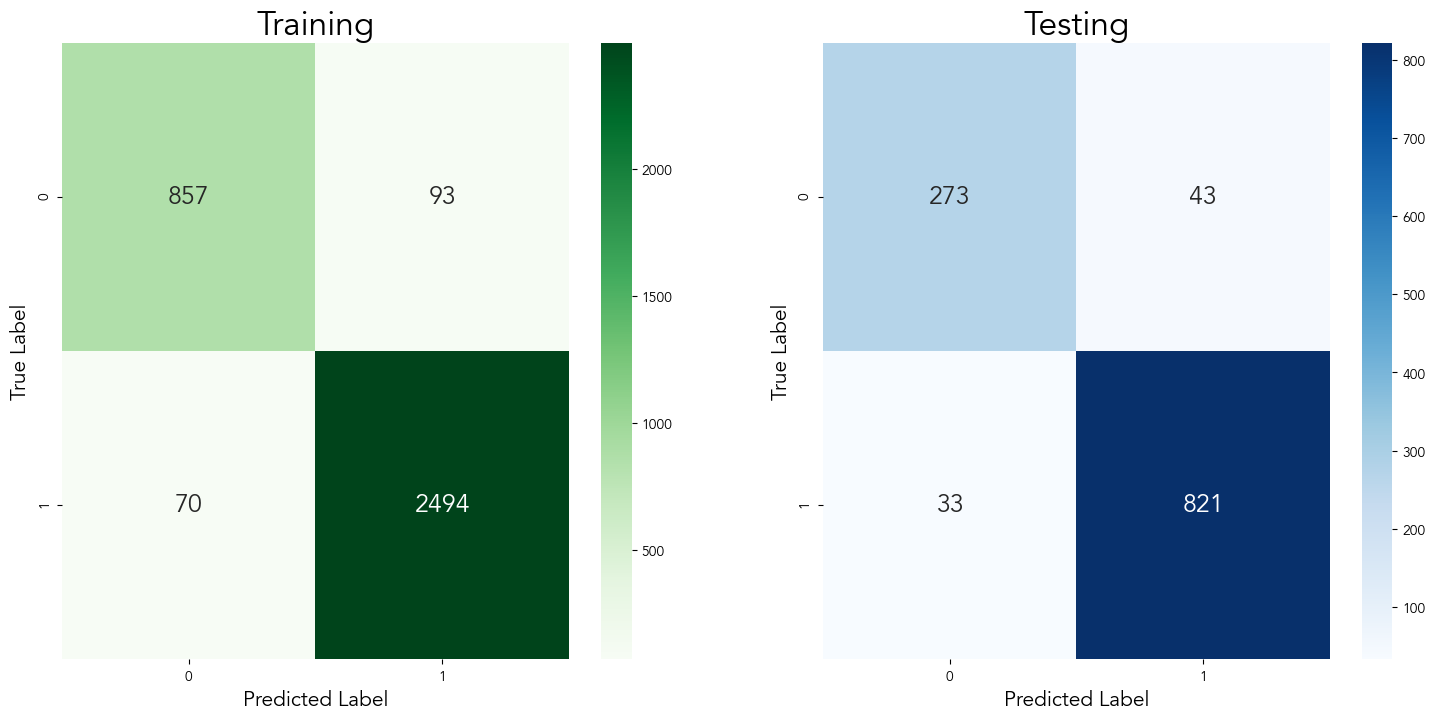

In [98]:
vis.plot_confusion_matrices(model2, train_images, test_images, train_labels, test_labels)
plt.show()
plt.savefig('images/confusion_matrices/cm_model2.png')

In [37]:
results_train = model2.evaluate(train_images, train_labels)

110/110 [==============================] - 0s 2ms/step - loss: 0.1294 - acc: 0.9536


In [38]:
results_test = model2.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 2ms/step - loss: 0.1724 - acc: 0.9350


In [39]:
results_train

[0.12940199673175812, 0.9536141157150269]

In [40]:
results_test

[0.172449991106987, 0.9350427389144897]

### Model 3: Neural Network with Dense and Drop Layers

In [41]:
np.random.seed(123)
model3 = models.Sequential()
model3.add(layers.Flatten(input_shape=(64, 64, 1)))
model3.add(layers.Dense(200, activation='relu'))
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(50, activation='relu'))
model3.add(layers.Dense(25, activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(7, activation='relu'))
model3.add(layers.Dense(5, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [42]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

history3 = model3.fit(train_images,
                     train_labels,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=(val_images, val_labels))

Epoch 1/30
110/110 [==============================] - 1s 7ms/step - loss: 0.6981 - acc: 0.5379 - val_loss: 0.6388 - val_acc: 0.7295
Epoch 2/30
110/110 [==============================] - 1s 6ms/step - loss: 0.6263 - acc: 0.7360 - val_loss: 0.5975 - val_acc: 0.7295
Epoch 3/30
110/110 [==============================] - 1s 6ms/step - loss: 0.5872 - acc: 0.7537 - val_loss: 0.5227 - val_acc: 0.8712
Epoch 4/30
110/110 [==============================] - 1s 5ms/step - loss: 0.5332 - acc: 0.8024 - val_loss: 0.4411 - val_acc: 0.9061
Epoch 5/30
110/110 [==============================] - 1s 5ms/step - loss: 0.4821 - acc: 0.8295 - val_loss: 0.4796 - val_acc: 0.8140
Epoch 6/30
110/110 [==============================] - 1s 5ms/step - loss: 0.4240 - acc: 0.8529 - val_loss: 0.3461 - val_acc: 0.9010
Epoch 7/30
110/110 [==============================] - 0s 4ms/step - loss: 0.3959 - acc: 0.8580 - val_loss: 0.4193 - val_acc: 0.8370
Epoch 8/30
110/110 [==============================] - 0s 4ms/step - loss: 0.

In [99]:
model3.save('models/model3.h5')

<Figure size 1000x700 with 0 Axes>

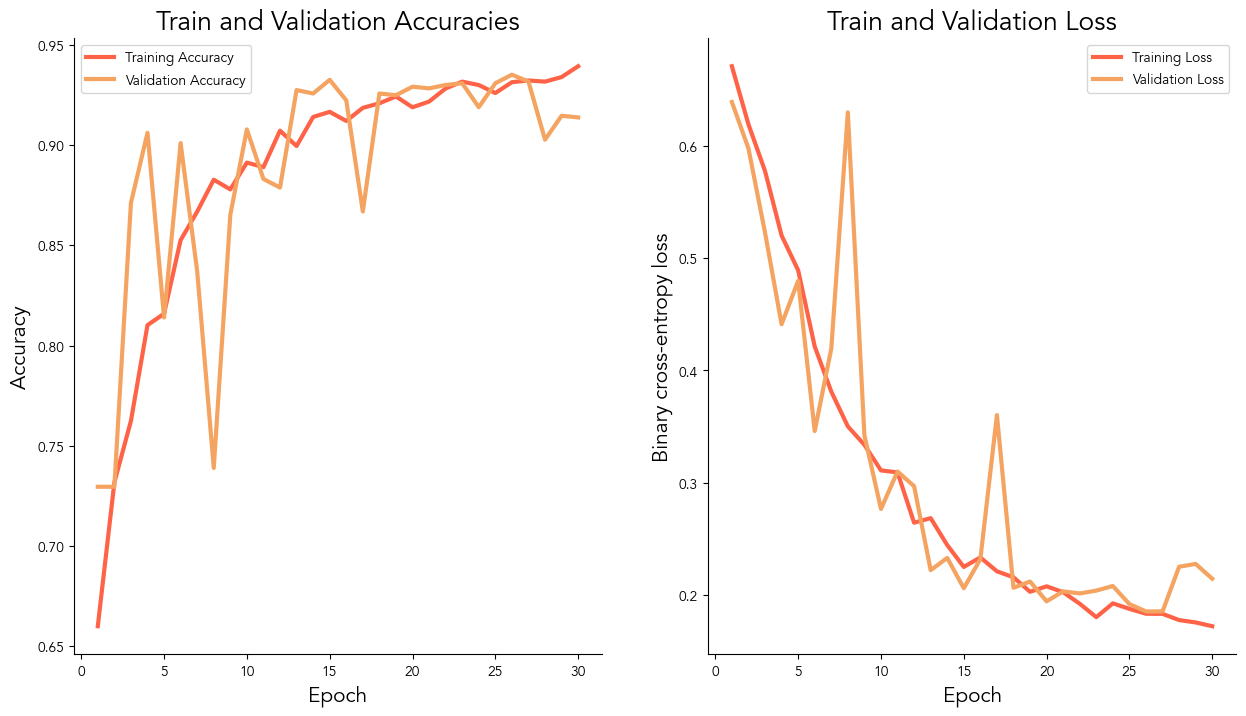

In [100]:
vis.plot_loss_accuracy(history3)
plt.show()
plt.savefig('images/acc_loss/al_model3.png')

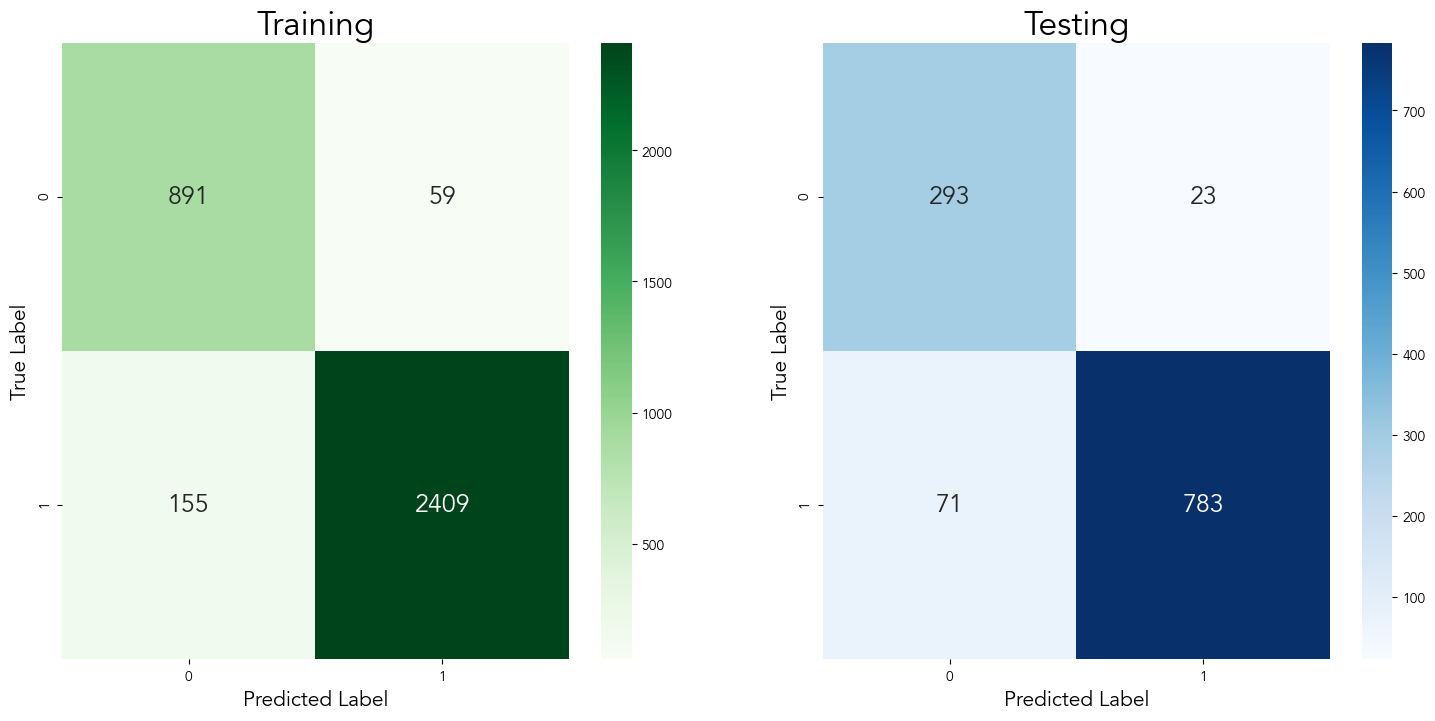

In [102]:
vis.plot_confusion_matrices(model3, train_images, test_images, train_labels, test_labels)
plt.show()
plt.savefig('images/confusion_matrices/cm_model3.png')

In [45]:
results_train = model3.evaluate(train_images, train_labels)

110/110 [==============================] - 0s 2ms/step - loss: 0.1622 - acc: 0.9391


In [46]:
results_test = model3.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 2ms/step - loss: 0.2133 - acc: 0.9197


In [47]:
results_train

[0.1621735394001007, 0.9391007423400879]

In [48]:
results_test

[0.21334320306777954, 0.9196581244468689]

### Model 4: Convolutional Neural Network (CNN)

In [49]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 1)))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [50]:
history4 = model4.fit(train_images,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_images, val_labels))

Epoch 1/30
110/110 [==============================] - 7s 58ms/step - loss: 0.6054 - acc: 0.7345 - val_loss: 0.5802 - val_acc: 0.7295
Epoch 2/30
110/110 [==============================] - 6s 58ms/step - loss: 0.5695 - acc: 0.7401 - val_loss: 0.5738 - val_acc: 0.7295
Epoch 3/30
110/110 [==============================] - 6s 59ms/step - loss: 0.5715 - acc: 0.7257 - val_loss: 0.5436 - val_acc: 0.7295
Epoch 4/30
110/110 [==============================] - 7s 60ms/step - loss: 0.5356 - acc: 0.7356 - val_loss: 0.5127 - val_acc: 0.8404
Epoch 5/30
110/110 [==============================] - 7s 60ms/step - loss: 0.4698 - acc: 0.7674 - val_loss: 0.3743 - val_acc: 0.8379
Epoch 6/30
110/110 [==============================] - 8s 70ms/step - loss: 0.4272 - acc: 0.8115 - val_loss: 0.3898 - val_acc: 0.8336
Epoch 7/30
110/110 [==============================] - 7s 67ms/step - loss: 0.3721 - acc: 0.8314 - val_loss: 0.2781 - val_acc: 0.8823
Epoch 8/30
110/110 [==============================] - 10s 94ms/step -

In [103]:
model4.save('models/model4.h5')

<Figure size 1000x700 with 0 Axes>

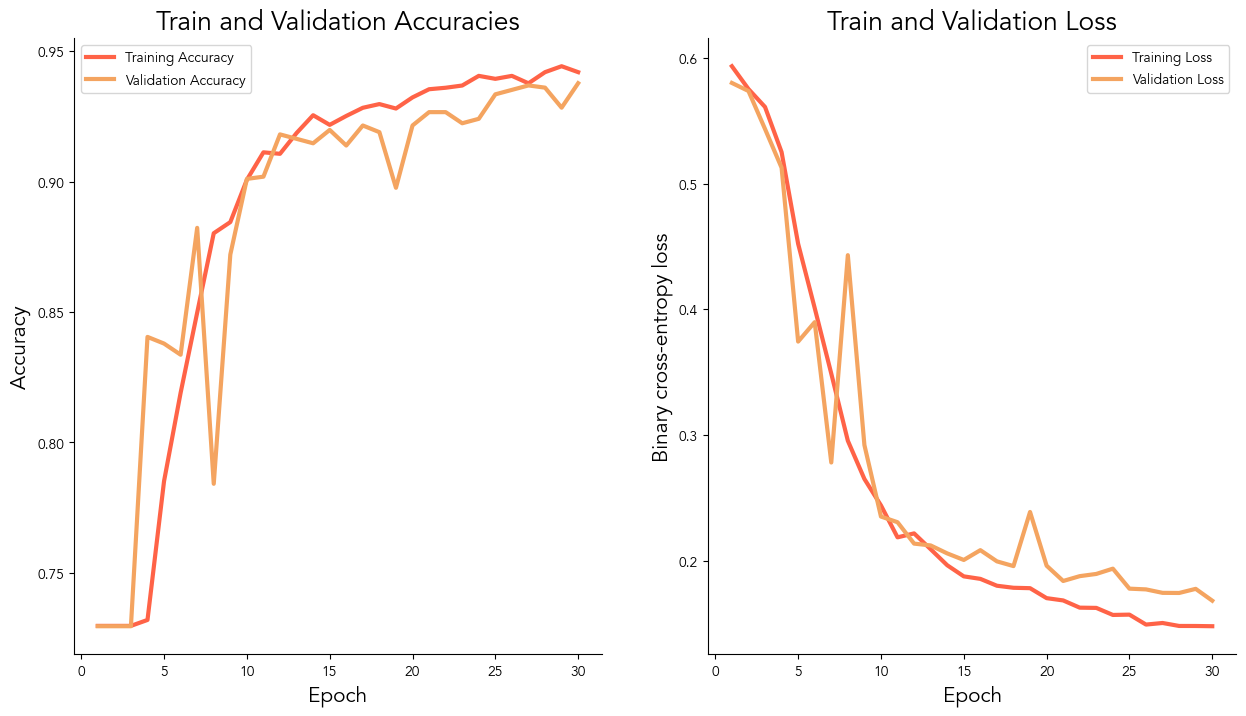

In [104]:
vis.plot_loss_accuracy(history4)
plt.show()
plt.savefig('images/acc_loss/al_model4.png')

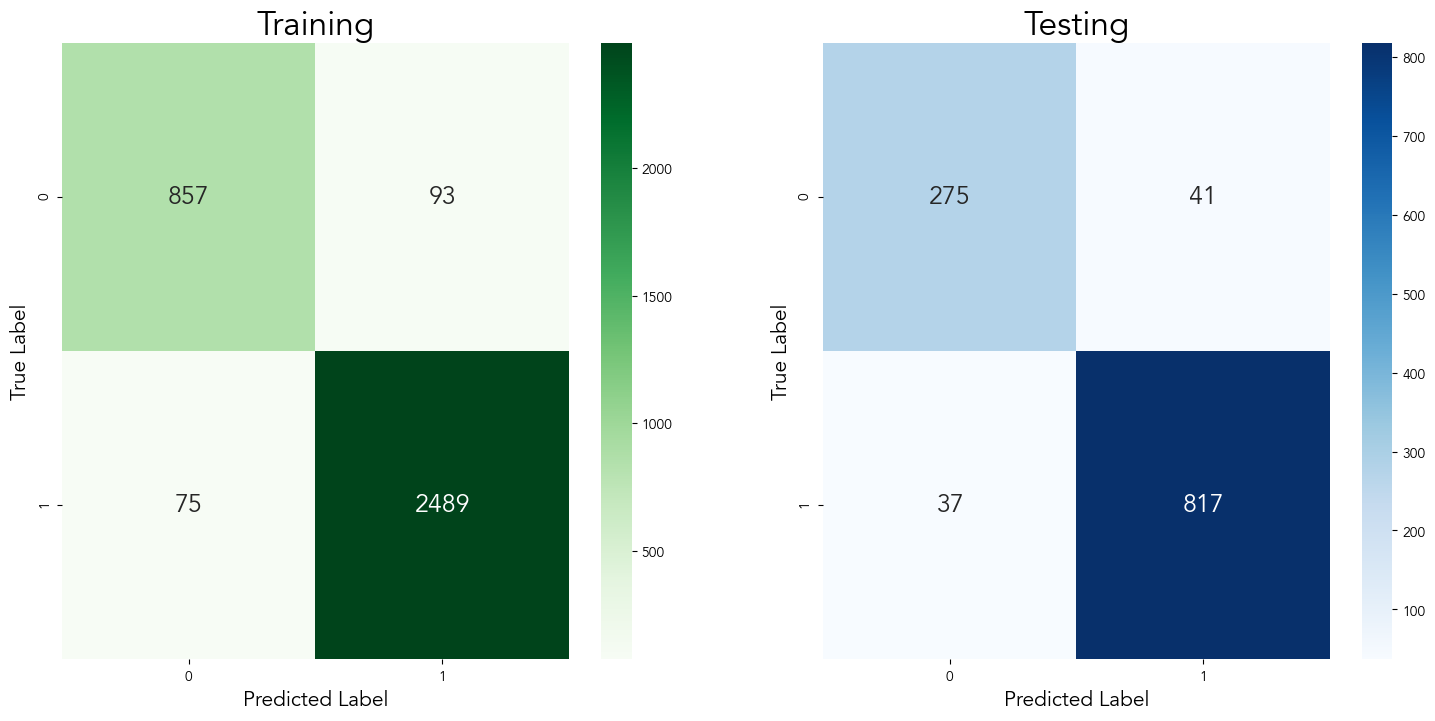

In [106]:
vis.plot_confusion_matrices(model4, train_images, test_images, train_labels, test_labels)
plt.show()
plt.savefig('images/confusion_matrices/cm_model4.png')

In [53]:
results_train = model4.evaluate(train_images, train_labels)

110/110 [==============================] - 2s 16ms/step - loss: 0.1304 - acc: 0.9522


In [54]:
results_test = model4.evaluate(test_images, test_labels)

37/37 [==============================] - 1s 17ms/step - loss: 0.1662 - acc: 0.9333


In [55]:
results_train

[0.13038557767868042, 0.9521912336349487]

In [56]:
results_test

[0.16615645587444305, 0.9333333373069763]

### Model 4.1: Base CNN with Class Weights

In [57]:
class_weight_dict = dict(zip([0, 1], class_weight))
class_weight_dict

{0: 1.8494736842105264, 1: 0.6852574102964119}

In [58]:
model4_1 = models.Sequential()
model4_1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 1)))
model4_1.add(layers.MaxPooling2D((2, 2)))

model4_1.add(layers.Conv2D(32, (4, 4), activation='relu'))
model4_1.add(layers.MaxPooling2D((2, 2)))

model4_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4_1.add(layers.MaxPooling2D((2, 2)))

model4_1.add(layers.Flatten())
model4_1.add(layers.Dense(64, activation='relu'))
model4_1.add(layers.Dense(1, activation='sigmoid'))

model4_1.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [59]:
history4_1 = model4_1.fit(train_images,
                    train_labels,
                    class_weight=class_weight_dict,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_images, val_labels))

Epoch 1/30
110/110 [==============================] - 7s 61ms/step - loss: 0.7062 - acc: 0.4050 - val_loss: 0.6892 - val_acc: 0.7176
Epoch 2/30
110/110 [==============================] - 6s 59ms/step - loss: 0.6883 - acc: 0.4917 - val_loss: 0.6810 - val_acc: 0.8874
Epoch 3/30
110/110 [==============================] - 7s 60ms/step - loss: 0.6796 - acc: 0.7198 - val_loss: 0.6724 - val_acc: 0.8857
Epoch 4/30
110/110 [==============================] - 7s 60ms/step - loss: 0.6765 - acc: 0.6263 - val_loss: 0.6840 - val_acc: 0.4915
Epoch 5/30
110/110 [==============================] - 7s 60ms/step - loss: 0.6438 - acc: 0.7584 - val_loss: 0.6298 - val_acc: 0.7662
Epoch 6/30
110/110 [==============================] - 7s 61ms/step - loss: 0.5883 - acc: 0.7479 - val_loss: 0.5141 - val_acc: 0.8072
Epoch 7/30
110/110 [==============================] - 7s 66ms/step - loss: 0.4840 - acc: 0.7805 - val_loss: 0.3090 - val_acc: 0.8925
Epoch 8/30
110/110 [==============================] - 8s 70ms/step - 

In [108]:
model4_1.save('models/model4_1.h5')

<Figure size 1000x700 with 0 Axes>

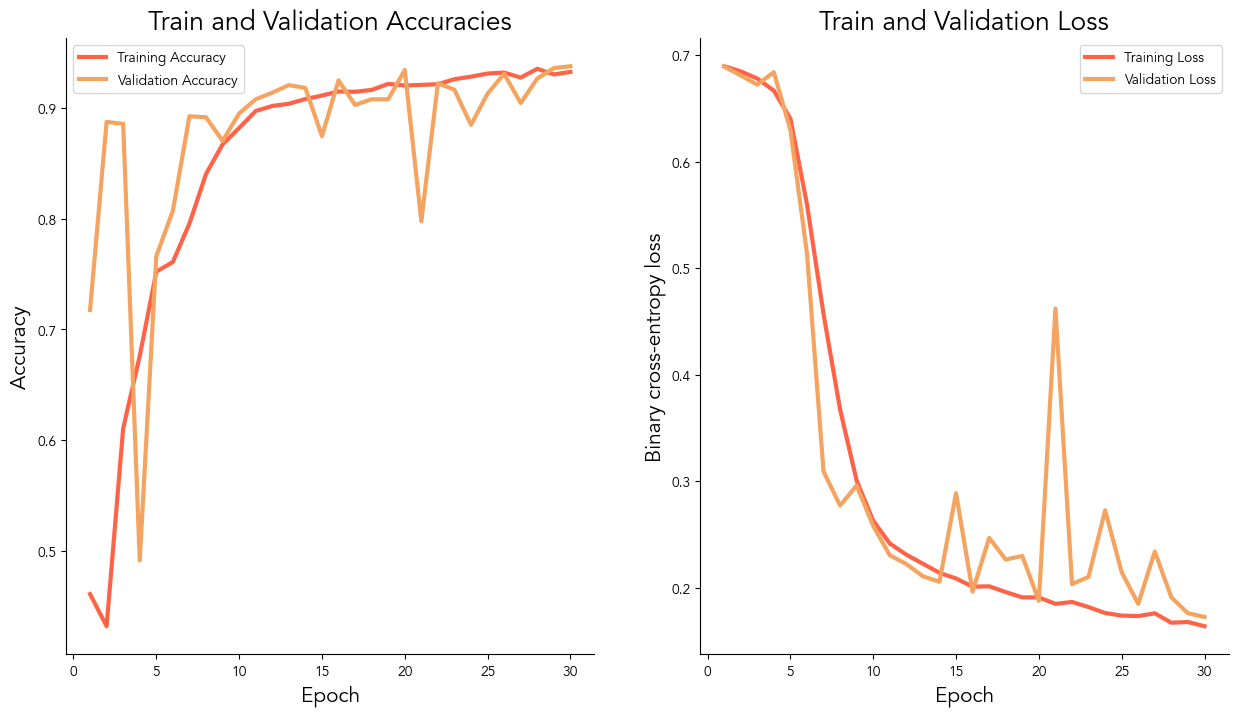

In [109]:
vis.plot_loss_accuracy(history4_1)
plt.show()
plt.savefig('images/acc_loss/al_model4_1.png')

<Figure size 1000x700 with 0 Axes>

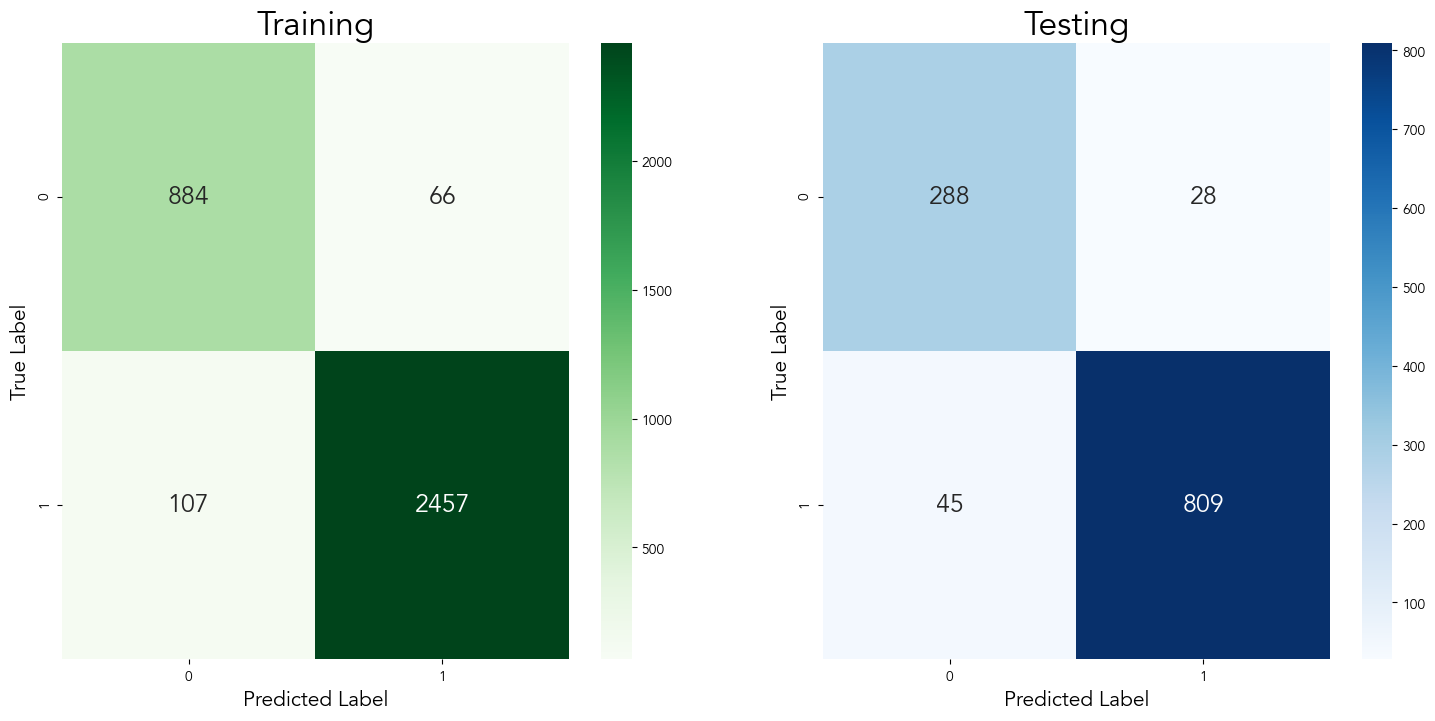

In [112]:
vis.plot_confusion_matrices(model4_1, train_images, test_images, train_labels, test_labels)
plt.show()
plt.savefig('images/confusion_matrices/cm_model4_1.png')

### Model 5: Base CNN with Focal Loss to solve class imbalance

In [63]:
#pip install focal-loss

In [64]:
from focal_loss import BinaryFocalLoss

In [65]:
model_fl = models.Sequential()
model_fl.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 1)))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Flatten())
model_fl.add(layers.Dense(64, activation='relu'))
model_fl.add(layers.Dense(1, activation='sigmoid'))

model_fl.compile(
    loss=BinaryFocalLoss(gamma=2),
    optimizer= 'sgd',
    metrics=['acc']
)

In [66]:
train_images.shape

(3514, 64, 64, 1)

In [67]:
val_images.shape

(1172, 64, 64, 1)

In [68]:
val_labels.shape

(1172,)

In [69]:
history_base_fl = model_fl.fit(
    train_images,
    train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_images, val_labels)
)

Epoch 1/30
110/110 [==============================] - 9s 72ms/step - loss: 0.1539 - acc: 0.6995 - val_loss: 0.1442 - val_acc: 0.7295
Epoch 2/30
110/110 [==============================] - 7s 60ms/step - loss: 0.1431 - acc: 0.7300 - val_loss: 0.1386 - val_acc: 0.7295
Epoch 3/30
110/110 [==============================] - 6s 59ms/step - loss: 0.1368 - acc: 0.7332 - val_loss: 0.1327 - val_acc: 0.7295
Epoch 4/30
110/110 [==============================] - 7s 60ms/step - loss: 0.1290 - acc: 0.7391 - val_loss: 0.1215 - val_acc: 0.7372
Epoch 5/30
110/110 [==============================] - 7s 62ms/step - loss: 0.1185 - acc: 0.7595 - val_loss: 0.1183 - val_acc: 0.7338
Epoch 6/30
110/110 [==============================] - 7s 61ms/step - loss: 0.1047 - acc: 0.8184 - val_loss: 0.1146 - val_acc: 0.7474
Epoch 7/30
110/110 [==============================] - 7s 66ms/step - loss: 0.0961 - acc: 0.8411 - val_loss: 0.0938 - val_acc: 0.8677
Epoch 8/30
110/110 [==============================] - 7s 61ms/step - 

In [113]:
model_fl.save('model5.h5')

In [70]:
# test_x_fl, test_y_fl = next(test_generator)

# results_test = model_fl.evaluate(test_x_fl, test_y_fl)

<Figure size 1000x700 with 0 Axes>

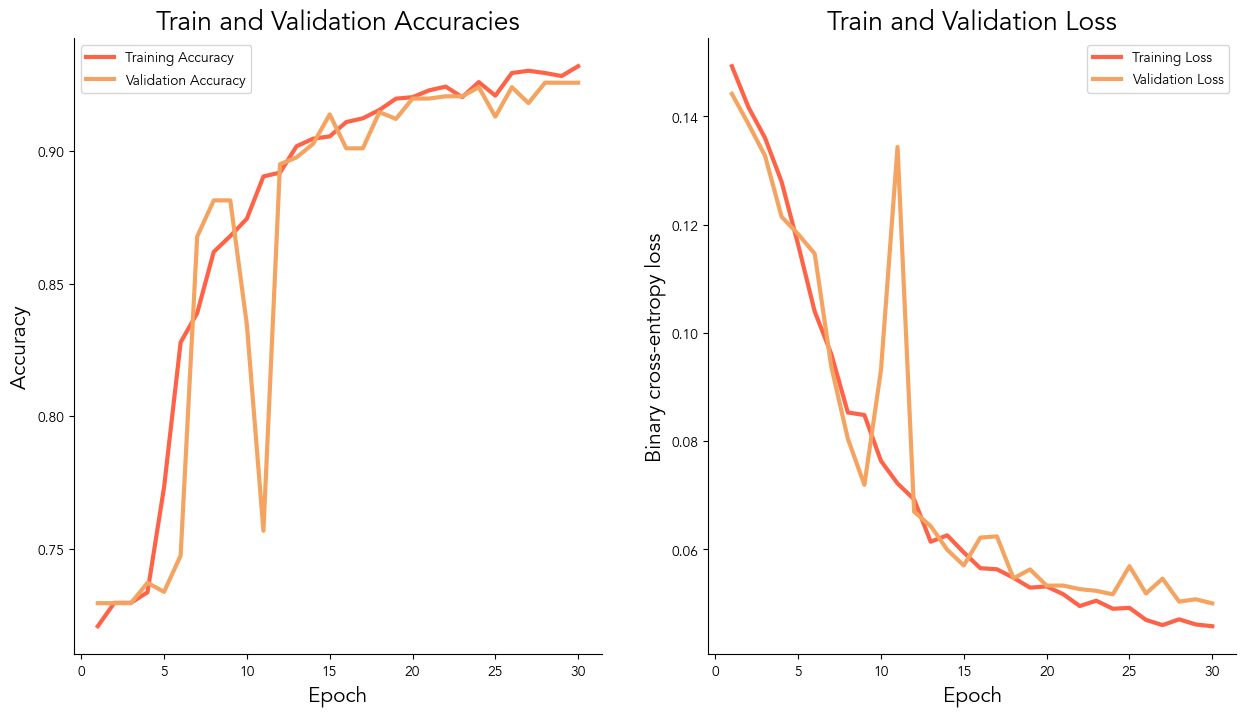

In [114]:
vis.plot_loss_accuracy(history_base_fl)
plt.show()
plt.savefig('images/acc_loss/al_model5.png')

<Figure size 1000x700 with 0 Axes>

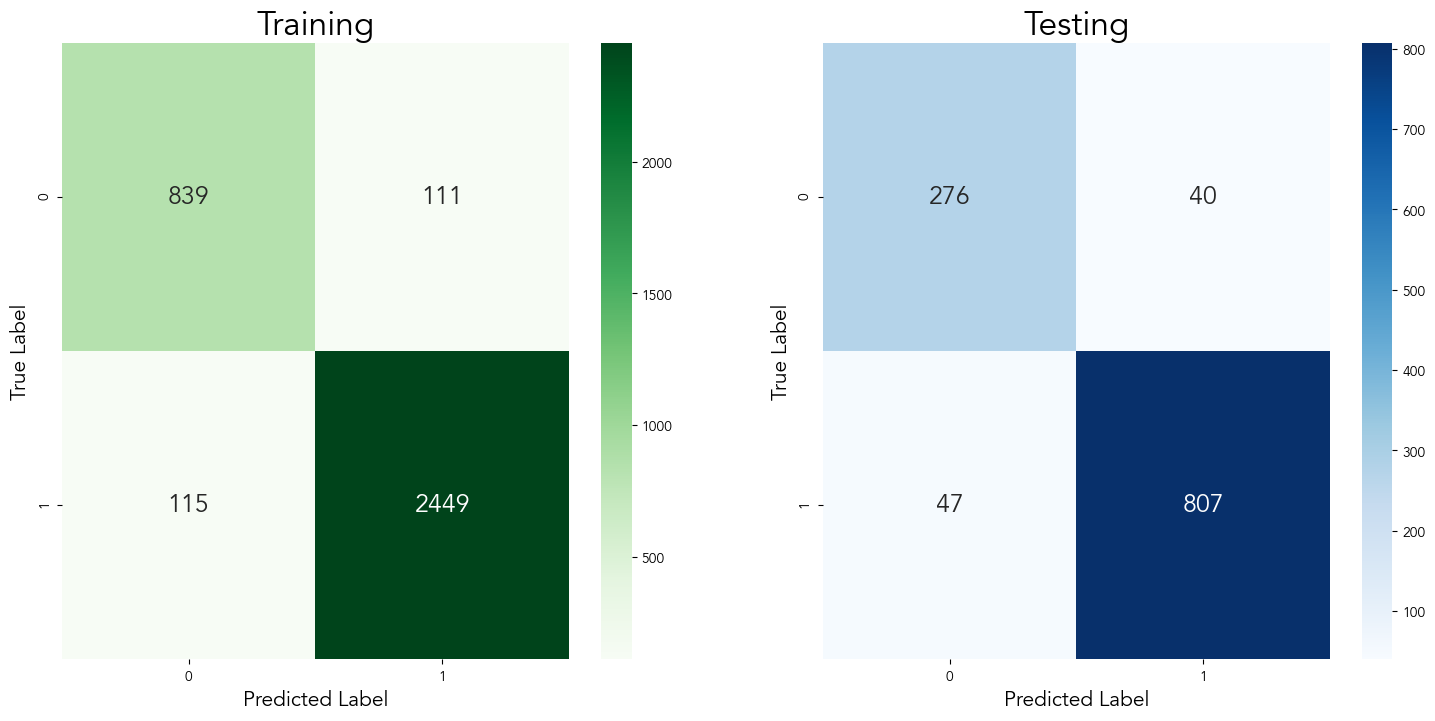

In [115]:
vis.plot_confusion_matrices(model_fl, train_images, test_images, train_labels, test_labels)
plt.show()
plt.savefig('images/confusion_matrices/cm_model5.png')

In [73]:
model_fl.summary()  

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)             

In [116]:
from sklearn.metrics import recall_score

recall_score()

In [75]:
class_weight = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels,
)

### Model 6: CNN with Image Augumentation 

In [82]:
train_datagen_aug = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3,
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

In [83]:
train_aug = train_datagen_aug.flow_from_directory(TRAIN_PATH,
                                               batch_size=BATCH_SIZE,
                                               target_size=(64,64),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")

test_aug = ImageDataGenerator(rescale=1./255).flow_from_directory(
        TEST_PATH, 
        target_size=(64, 64), 
        batch_size = BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
val_aug = ImageDataGenerator(rescale=1./255).flow_from_directory(
        VAL_PATH, 
        target_size=(64, 64),
        batch_size = BATCH_SIZE,
        class_mode='binary')

Found 3514 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


In [90]:
model_aug = models.Sequential()
model_aug.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Flatten())
model_aug.add(layers.Dense(64, activation='relu'))
model_aug.add(layers.Dense(1, activation='sigmoid'))

model_aug.compile(loss=BinaryFocalLoss(gamma=2),
              optimizer= 'sgd',
              metrics=['acc'])

In [91]:
history_aug = model_aug.fit(
    train_aug, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_aug
)

Epoch 1/30
 44/110 [===========>..................] - ETA: 16s - loss: 0.1540 - acc: 0.7357

KeyboardInterrupt: 

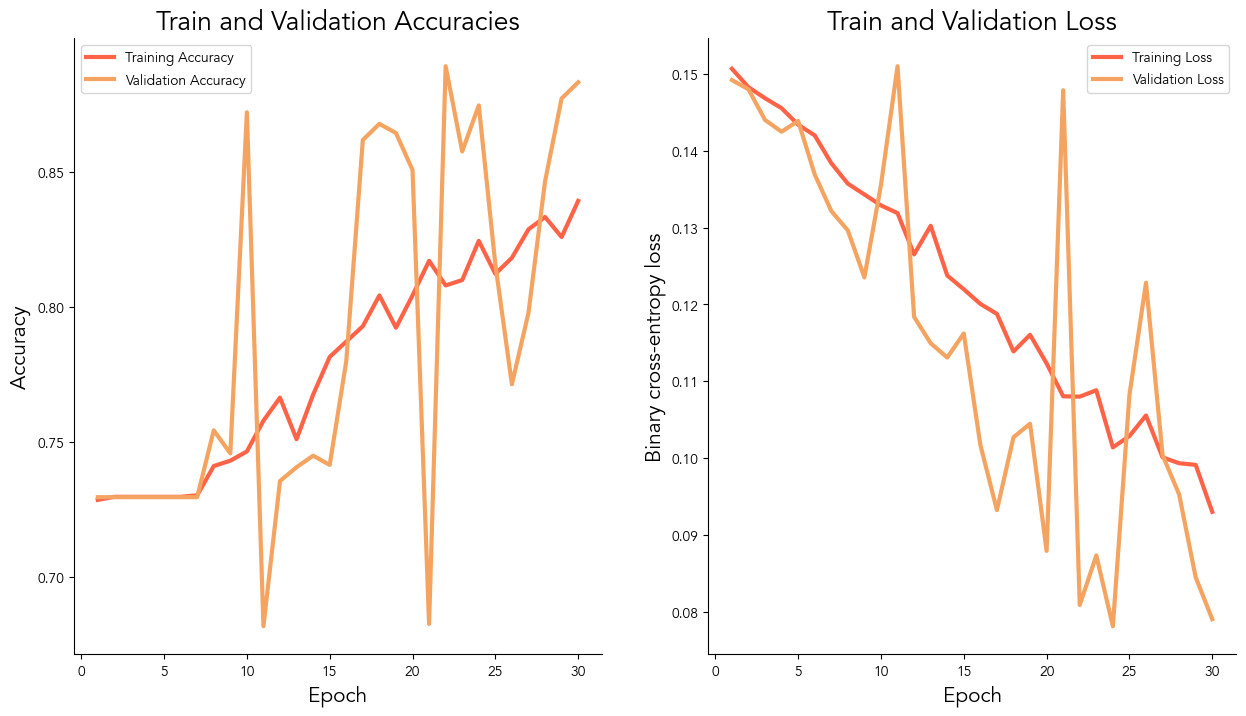

In [86]:
vis.plot_loss_accuracy(history_aug)
plt.show()
plt.savefig('images/acc_loss_cnn_aug.png')

In [87]:
vis.plot_confusion_matrices(model_aug, train_images, test_images, train_labels, test_labels)

ValueError: in user code:

    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/iansharff/opt/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_7 is incompatible with the layer: expected axis -1 of input shape to have value 3 but received input with shape (None, 64, 64, 1)


In [ ]:
test_results_aug = model_aug.evaluate(test_aug)

In [ ]:
model_aug.summary()

## Analysis, Conclusions, and Future Work